[tokei](https://github.com/XAMPPRocky/tokei) is a neat tool for
providing statistics on a codebase. Let's look at it run over
the source code of git.

In [1]:
import json
import re
import subprocess
from pathlib import Path

In [2]:
git_repo = Path.home() / "code" / "git"

In [3]:
tokei_run = subprocess.run(
    ["tokei"],
    cwd=git_repo,
    stdout=subprocess.PIPE,
    encoding="utf-8",
)
print(tokei_run.stdout)

 Language            Files        Lines         Code     Comments       Blanks
 ASP.NET                 9         1083          942            0          141
 GNU Style Assembly      1          224           98          100           26
 Autoconf                9          128          108            3           17
 BASH                    1         3585         2866          431          288
 Batch                   3          287          117          118           52
 C                     475       284504       220346        29119        35039
 C Header              228        36873        18580        13629         4664
 CMake                   1          988          779           50          159
 CSS                     2          982          783           30          169
 Emacs Lisp              2           12           12            0            0
 Go                      4          558          421           84           53
 JavaScript              3         1065          513

It's rather amazing that the source code contains nearly
300,000 lines of C code and just as many lines of shell scripts.
It's also interesting to consider how that's changed over
time. We can look at this by analyzing each version of git and
plotting its growth.

Let's start by looking at the tags in git's history with the
`git tag` command. 

In [4]:
git_tag = subprocess.run(
    ["git", "tag"],
    cwd=git_repo,
    stdout=subprocess.PIPE,
    encoding="utf-8",
)
tags = git_tag.stdout.split("\n")

Analyzing the tags shows a few things in the raw tag output
that we'd like to fix. One is that there are a number of tags
for gitgui versions that we're not really interested in.

In [5]:
tags[:3]

['gitgui-0.10.0', 'gitgui-0.10.1', 'gitgui-0.10.2']

Another thing that we'll want to fix is that git tags are printed in
alphanumeric order, which means that the tag v2.19 comes before v2.2
even though it's a later version number.

In [6]:
tags[619:624]

['v2.19.3', 'v2.19.4', 'v2.19.5', 'v2.2.0', 'v2.2.0-rc0']

`git tag` provides two handy switches to resolve this. The first is
`--list pattern` which only lists tags that match the given pattern.
The pattern `v[0-9].[0-9]*.0` only matches tags that start with a v,
followed by a single digit, followed by a period, followed by one or more
digits, followed by a period, and ending with a 0.

The second handy switch is a `--sort=version:refname` which will sort
the tags such that `v2.19` comes after `v2.2`.

In [7]:
git_tag = subprocess.run(
    [
        "git", "tag", "--list", 'v[0-9].[0-9]*.0',
        "--sort=version:refname"
    ],
    cwd=git_repo,
    stdout=subprocess.PIPE,
    encoding="utf-8",
)
# this call mysteriously adds a blank line at the end
# which we remove by taking everything except for
# the last element
tags = git_tag.stdout.split("\n")[:-1]
print(tags)

['v1.0.0', 'v1.1.0', 'v1.2.0', 'v1.3.0', 'v1.4.0', 'v1.5.0', 'v1.6.0', 'v1.7.0', 'v1.8.0', 'v1.9.0', 'v2.0.0', 'v2.1.0', 'v2.2.0', 'v2.3.0', 'v2.4.0', 'v2.5.0', 'v2.6.0', 'v2.7.0', 'v2.8.0', 'v2.9.0', 'v2.10.0', 'v2.11.0', 'v2.12.0', 'v2.13.0', 'v2.14.0', 'v2.15.0', 'v2.16.0', 'v2.17.0', 'v2.18.0', 'v2.19.0', 'v2.20.0', 'v2.21.0', 'v2.22.0', 'v2.23.0', 'v2.24.0', 'v2.25.0', 'v2.26.0', 'v2.27.0', 'v2.28.0', 'v2.29.0']


Now that we've got all versions captured in order, let's run tokei
over v1.0.0 and see what git looked like at the time.

In [8]:
subprocess.run(
    ["git", "checkout", tags[0]],
    cwd=git_repo,
    encoding="utf-8",
    check=True
)
tokei = subprocess.run(
    ["tokei"],
    cwd=git_repo,
    stdout=subprocess.PIPE,
    encoding="utf-8"
)
print(tokei.stdout)

 Language            Files        Lines         Code     Comments       Blanks
 GNU Style Assembly      2          369          274           48           47
 Autoconf                1          188          152            2           34
 C                     111        32617        26384         2664         3569
 C Header               25         1424          948          219          257
 Makefile                4          687          451          116          120
 Perl                    1           69           60            1            8
 Python                  3         2333         2035           80          218
 Shell                 107        16366        13595         1163         1608
 Plain Text            127        13434            0        10313         3121
 Total                 381        67487        43899        14606         8982



26,000 lines of C and nearly 15,000 lines of shell scripts are
nothing to sneeze at, but let's look again at the statistics
of git today.

In [9]:
subprocess.run(
    ["git", "checkout", tags[-1]],
    cwd=git_repo,
    encoding="utf-8",
    check=True,
)
tokei = subprocess.run(
    ["tokei"],
    cwd=git_repo,
    stdout=subprocess.PIPE,
    encoding="utf-8"
)
print(tokei.stdout)

 Language            Files        Lines         Code     Comments       Blanks
 ASP.NET                 9         1083          942            0          141
 GNU Style Assembly      1          224           98          100           26
 Autoconf                9          128          108            3           17
 BASH                    1         3585         2866          431          288
 Batch                   3          287          117          118           52
 C                     475       284504       220346        29119        35039
 C Header              228        36873        18580        13629         4664
 CMake                   1          988          779           50          159
 CSS                     2          982          783           30          169
 Emacs Lisp              2           12           12            0            0
 Go                      4          558          421           84           53
 JavaScript              3         1065          513

At 280,000 lines of C and 260,000 lines of shell scripts, git has
grown to over ten times the size of its original release in 2005!

Finally, let's use [seaborn](https://seaborn.pydata.org/) to visualize
git's growth over time. We'll check out each version one by one, run
`tokei --output json`, and store the number of lines of C code in each
version.

In [10]:
line_lens = []

for tag in tags:
    subprocess.run(
        ["git", "checkout", tag],
        cwd=git_repo,
        encoding="utf-8",
    )
    tokei = subprocess.run(
        ["tokei", "--output", "json"],
        cwd=git_repo,
        stdout=subprocess.PIPE,
        encoding="utf-8"
    )
    tokei_json = json.loads(tokei.stdout)
    c_lines = tokei_json["C"]["code"]
    line_lens.append(c_lines)

We'll plot the tags on the x-axis (only displaying every 5th tag
for space) and the number of lines of C code on the y-axis to see
the rate at which git's codebase has grown by version.

In [11]:
import seaborn as sns

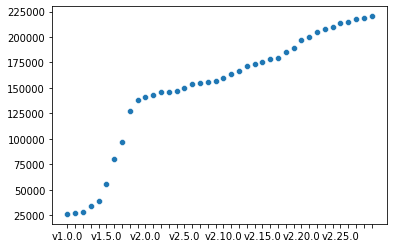

In [12]:
plt = sns.scatterplot(x=tags, y=line_lens)
for ind, label in enumerate(plt.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)